In [1]:
from utils import SeqDataset
import torch, numpy as np
import os, pickle, argparse, pandas as pd
from importlib import import_module
from matplotlib import colors, pyplot as plt
import seaborn

import shap
from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence

In [2]:
PREFIX_DATA="/net/talisker/home/benos/mae117/Documents/research/chikina/ATAConv/data"
FOLD_NUM=9

In [116]:
def read_from_pickle(filepath):
  with open(filepath, "rb") as file:
    data = pickle.load(file)
  return data

def interpret_input_grad(model, x):
    torch.set_grad_enabled(True)
    x_np = x.cpu().numpy()
    x = x.to(device)
    x.requires_grad = True
    pred = model(x)
    model.zero_grad()
    input_grads, = torch.autograd.grad(outputs=pred[0][0], inputs=x, retain_graph=True)
    return input_grads.cpu().numpy() * x_np

def interpret_deepshap(model, x):

    x_np = x.cpu().numpy()
    torch.set_grad_enabled(True)
    x = x.to(device)
    x.requires_grad = True

    class WrapperModel(torch.nn.Module):
        def __init__(self, inner_model):
            super().__init__()
            self.inner_model = inner_model
        def forward(self, input_data):
            return(self.inner_model(input_data))

    # Create wrapper model whose sole output is B x 1 tensor, which DeepSHAP
    # requires
    wrapper_model = WrapperModel(model)

    def bg_func(x_np): 
        return torch.tensor(dinuc_shuffle(x_np.squeeze(), 10)).to(device).float()

    explainer = shap.DeepExplainer(model=wrapper_model, data=bg_func(x_np))
    scores = explainer.shap_values(x)[0]
    return(scores * x_np)

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

meme_file = f"{PREFIX_DATA}/memes/cisBP_mouse.meme"
signal_file = f"{PREFIX_DATA}/lineages/lineageImmgenDataCenterNK.txt" 
sequence_file = f"{PREFIX_DATA}/sequences/sequences.list"
model_name = f"/net/talisker/home/benos/mae117/Documents/research/chikina/ATAConv/data/model_outputs/centernk_fourier-False/10foldcv/fold_{FOLD_NUM}"
split_folder = f"/net/talisker/home/benos/mae117/Documents/research/chikina/ATAConv/data/splits_all/10foldcv/fold_{FOLD_NUM}"
architecture_name = "model_pos_calib_sigmoid"
window_size = 300
batch_size = 254
num_of_workers = 8
file_stat = None
isaiatac = False
class_name = "TISFM"
usevalidation = False
plotpath = False
plotxlog = False
plotfinallayer = False
plotshap = True
topmotifs = 10
model_index = None
extract_final_layer = None

dataset = SeqDataset(signal_file, sequence_file)

architecture = getattr(import_module(f"models.{architecture_name}"), class_name)

model = architecture(dataset.number_of_cell_types(), meme_file, window_size).to(device)

if usevalidation:
  file_name = "best_validation.tsv"
else:
  file_name = "best_test.tsv"

if usevalidation:
  indices = np.load(os.path.join(split_folder, "validation_split.npy"))
else:
  indices = np.load(os.path.join(split_folder, "test_split.npy"))

dataset_sample = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=1)

dataset_subset = torch.utils.data.Subset(dataset, list(dataset_sample))

dataloader = torch.utils.data.DataLoader(dataset_subset, num_workers = num_of_workers)

loss = torch.nn.MSELoss(reduction="none")

names = dataset.cell_types()

if os.path.isdir(model_name):
  if os.path.exists(os.path.join(model_name, "model.best")):
    if file_stat is None:
        file_stat = os.path.join(model_name, file_name)
    model_name = os.path.join(model_name, f"model.best")
  else:
    stats = read_from_pickle(os.path.join(model_name, "stats.pkl"))
    ii = np.argmin(stats["validation_average_loss"])
    print(f"Best model validation MSE: {stats['validation_average_loss'][ii]}, Epoch: {stats['epoch'][ii]}.")
    if file_stat is None:
        file_stat = os.path.join(model_name, file_name)
    model_name = os.path.join(model_name, f"model.{stats['epoch'][ii]}")

model.load_model(model_name)

tiSFM without any added FT-prior:
#==============================================================================#
Input gradients


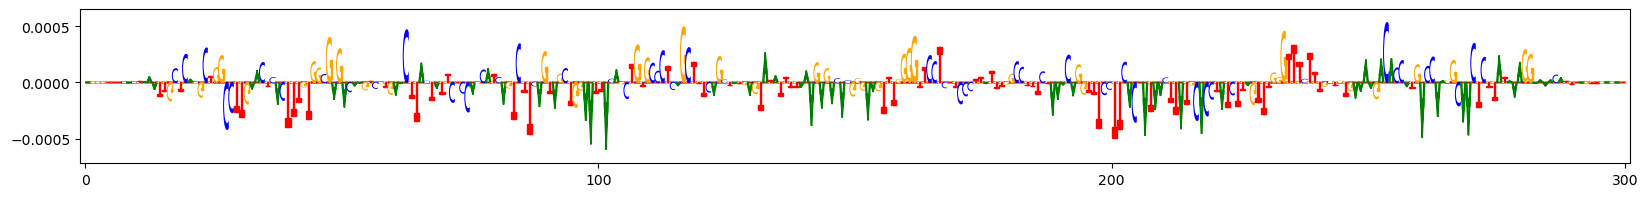

DeepSHAP


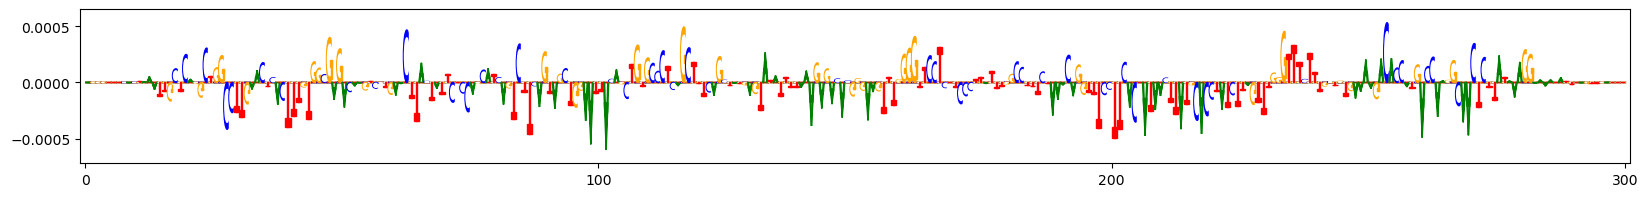

In [120]:
# with torch.no_grad():
#   model.eval()
for x, y in dataloader:
  print("tiSFM without any added FT-prior:")
  print("#==============================================================================#")
  print("Input gradients")
  viz_sequence.plot_weights(interpret_input_grad(model, x).squeeze().T, subticks_frequency=100)

  print("DeepSHAP")
  viz_sequence.plot_weights(interpret_deepshap(model, x),subticks_frequency=100)